In [1]:
# %load_ext iminizinc
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
# import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
from decimal import *
getcontext().prec = 6
# import seaborn as sns
# from scipy.signal import find_peaks, peak_widths
import pickle


import sys, os
# sys.path.append(os.path.abspath('..'))
from lib.utils import load_candles


# import mplfinance as mpf
%matplotlib inline

plt.rcParams['lines.linewidth'] = 0.5 

mpl.rcParams.update({'font.size': 10, 'lines.linewidth': 0.5, 'figure.dpi': 300})


In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

# optional 'chdir' (if not installed via 'pip' -> ModuleNotFoundError)
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
import os
# module_path = './gym_pk'
# if not os.path.exists(module_path):
#     os.chdir('../')
# ------------------------------------------------------------

import gymnasium as gym
import gym_pk
from gym_pk.agents import QAgent

from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
pair = 'BTC_USDT'
timeframe = '4h'

exchange = 'binance'
odf = load_candles(exchange=exchange, pair=pair, timeframe=timeframe)

odf['cdir'] = -1 + 2 *(odf.close > odf.open)
odf['grflip'] = (odf.cdir != odf.cdir.shift()).fillna(0).cumsum()
odf['cudir'] = odf[['cdir', 'grflip']].groupby('grflip')[['cdir']].cumsum().clip(-7,7)

odf['lret'] = odf.close.divide(odf.open).apply(np.log)


horizon = 1
future_prices = pd.DataFrame(dict(min_low_ret=odf.low.rolling(horizon).min().shift(-horizon).divide(odf.close).apply(np.log),
max_high_ret=odf.high.rolling(horizon).max().shift(-horizon).divide(odf.close).apply(np.log),
close_ret=odf.close.shift(-horizon).divide(odf.close).apply(np.log))
).dropna()

odf = odf.loc[future_prices.index].sort_index()
# odf['ncudir'] = odf.cudir.add(5).subtract(odf.cudir > 0)
# odf = odf['2020-01-01':]


In [85]:
odf

,timestamp,open,high,low,close,volume,cdir,grflip,cudir,lret
dtime,,,,,,,,,,
2017-08-17 04:00:00,1502942400000,4261.48,4349.99,4261.32,4349.99,82.088865,1,1,1,0.020557
2017-08-17 08:00:00,1502956800000,4333.32,4485.39,4333.32,4427.30,63.619882,1,1,2,0.021456
2017-08-17 12:00:00,1502971200000,4436.06,4485.39,4333.42,4352.34,174.562001,-1,2,-1,-0.019053
2017-08-17 16:00:00,1502985600000,4352.33,4354.84,4200.74,4325.23,225.109716,-1,2,-2,-0.006246
2017-08-17 20:00:00,1503000000000,4307.56,4369.69,4258.56,4285.08,249.769913,-1,2,-3,-0.005232
...,...,...,...,...,...,...,...,...,...,...
2023-06-01 12:00:00,1685620800000,26892.95,26981.34,26782.53,26894.48,6481.675460,1,6921,3,0.000057
2023-06-01 16:00:00,1685635200000,26894.47,27175.00,26656.00,26862.68,8974.247130,-1,6922,-1,-0.001183
2023-06-01 20:00:00,1685649600000,26862.68,26942.98,26713.34,26817.93,3659.356110,-1,6922,-2,-0.001667


In [86]:
features = ['cudir']

cat_features = odf[features].astype('category')
cat_feature_codes = cat_features.apply(lambda x: x.cat.codes)
cat_feature_counts = cat_features.dtypes.apply(lambda x: x.categories.shape[0])
cat_feature_counts


cudir    14
dtype: int64

In [87]:
from gymnasium.spaces import Tuple, Discrete
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

state_features_specs = [('cudir', 1), ('cudir', 3), ('cudir', 5), ('cudir', 7)]

# lagged_feature_codes = pd.concat({
#     k:v
#     for i, (feature, lag) in enumerate(lagged_features_specs)
#     for k in [f'{i}__{feature}_LAG_{lag}']
#     for v in [cat_feature_codes[feature].shift(lag)]
# }, axis=1).dropna().astype(int)#.values

# lagged_feature_codes.agg(lambda x:  print(x.values), axis=1)

signal_features = pd.concat({
    k:v
    for i, (feature, lag) in enumerate(state_features_specs)
    for k in [f'{feature}_LAG_{lag}']
    for v in [cat_features[feature].shift(lag)]
}, axis=1).dropna().astype(int)#.values


# state_features['feat_cat'] = state_features.agg(lambda x:  np.array2string(x.values, separator=',', formatter={'int_kind': lambda x: "{:>+}".format(x)}), axis=1)

# le.fit(state_features['feat_cat'])
if 'state_no' in odf.columns:
    odf.drop('state_no', axis=1, inplace=True)

# state_features['state_no'] = le.transform(state_features['feat_cat'].values).astype(int)
# state_features
# state_features[['state_no']]
# odf = odf.join(state_features[['state_no']]).dropna()
odf = odf.loc[signal_features.index].sort_index()
# odf
signal_features

le = preprocessing.LabelEncoder()
le_fits = [le.fit(signal_features[c]) for c in signal_features.columns]
le_dims = [le_.classes_.shape[0] for le_ in le_fits]
observation_space = Tuple([Discrete(n) for n in le_dims])

state_features = pd.DataFrame({
        signal_features.columns[i] : le_fits[i].transform(signal_features.iloc[:,i]) for i in range(len(le_fits))
    }, index=signal_features.index)
state_tuples = state_features.apply(tuple, axis=1)
odf['state_features'] = state_tuples
odf

,timestamp,open,high,low,close,volume,cdir,grflip,cudir,lret,state_features
dtime,,,,,,,,,,,
2017-08-18 08:00:00,1503043200000,4285.00,4371.52,4259.85,4340.31,196.140129,1,3,3,0.012825,"(8, 4, 6, 7)"
2017-08-18 12:00:00,1503057600000,4320.52,4340.31,4193.70,4236.89,175.969384,-1,4,-1,-0.019546,"(9, 7, 5, 8)"
2017-08-18 16:00:00,1503072000000,4234.54,4297.75,4015.70,4136.28,193.646970,-1,4,-2,-0.023478,"(6, 8, 4, 6)"
2017-08-18 20:00:00,1503086400000,4135.00,4136.48,3938.77,4108.37,109.549709,-1,4,-3,-0.006461,"(5, 9, 7, 5)"
2017-08-19 00:00:00,1503100800000,4108.37,4184.69,4084.28,4138.55,108.510448,1,5,1,0.007319,"(4, 6, 8, 4)"
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01 12:00:00,1685620800000,26892.95,26981.34,26782.53,26894.48,6481.675460,1,6921,3,0.000057,"(8, 6, 7, 3)"
2023-06-01 16:00:00,1685635200000,26894.47,27175.00,26656.00,26862.68,8974.247130,-1,6922,-1,-0.001183,"(9, 7, 8, 2)"
2023-06-01 20:00:00,1685649600000,26862.68,26942.98,26713.34,26817.93,3659.356110,-1,6922,-2,-0.001667,"(6, 8, 6, 7)"


In [88]:
train_ratio = 0.15
i_test_start = int(odf.shape[0] * train_ratio)
X_odf_train = odf.iloc[:i_test_start]
X_odf_test = odf.iloc[i_test_start+1:]
X_state_train = state_features.iloc[:i_test_start]
X_state_test = state_features.iloc[i_test_start+1:]
X_future_train = future_prices.iloc[:i_test_start]
X_future_test = future_prices.iloc[i_test_start+1:]

X_train = X_odf_train.join(X_state_train).join(X_future_train)
X_test = X_odf_test.join(X_state_test).join(X_future_test)


In [89]:
import random
from gym_pk.agents import QAgent, MonteCarloAgent, SarsaAgent

window_size = 6 * 7 * 1
# start_index = window_size
# end_index = start_index + len(df)

env = gym.make(
    "crypto-v0",
    # window_size = window_size,
    max_episode_steps=500,
    df = X_train,
    state_features = X_state_train,
    future_prices = X_future_train,
    observation_space = observation_space
)

#reproduce training and test
seed = 42
obs = env.reset(seed=seed,options=dict(_start_tick=0, _end_tick=1000) )
# random.seed(seed)

# hyperparameters
learning_rate = 0.3
n_episodes = 300
start_epsilon = 1
# epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.01

agent = QAgent(action_space=env.action_space, aparams=dict(
    alpha=learning_rate,
    gamma=0.7,
    initial_epsilon=start_epsilon,
    epsilon_decay=start_epsilon / (n_episodes * window_size/ 2),
    final_epsilon=final_epsilon,
    action_space=env.action_space)
)

####################
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset(options=dict(_start_tick=0, _end_tick=1000))
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

print(env.unwrapped._total_reward)

/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(
 21%|██        | 206/1000 [00:13<00:55, 14.21it/s]

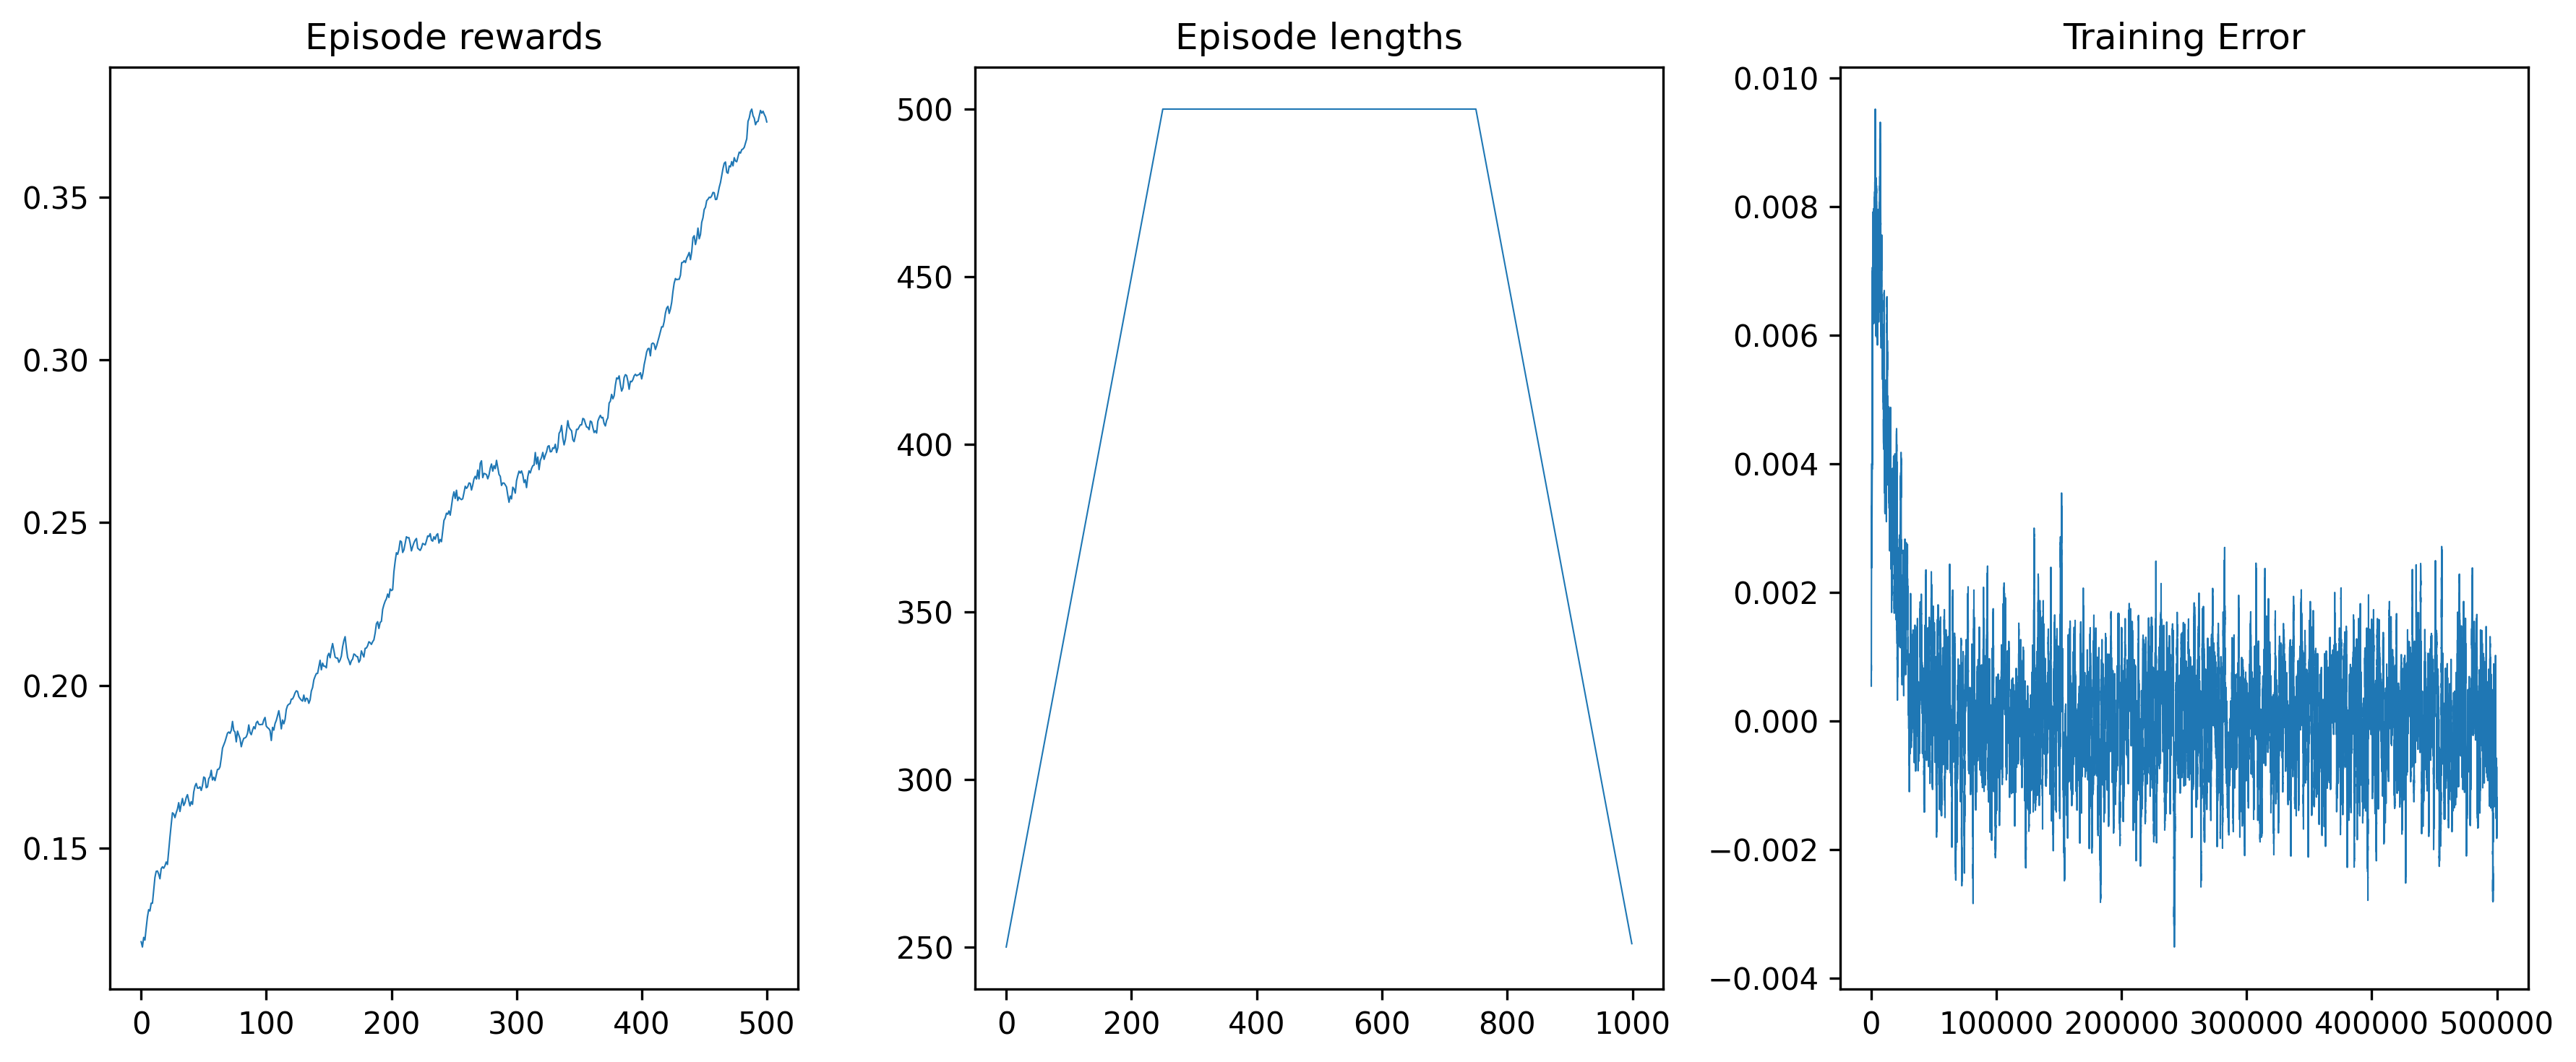

In [82]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

In [534]:
rets.oaction.sum().sum() * 0.002

1.48

<Axes: xlabel='dtime'>

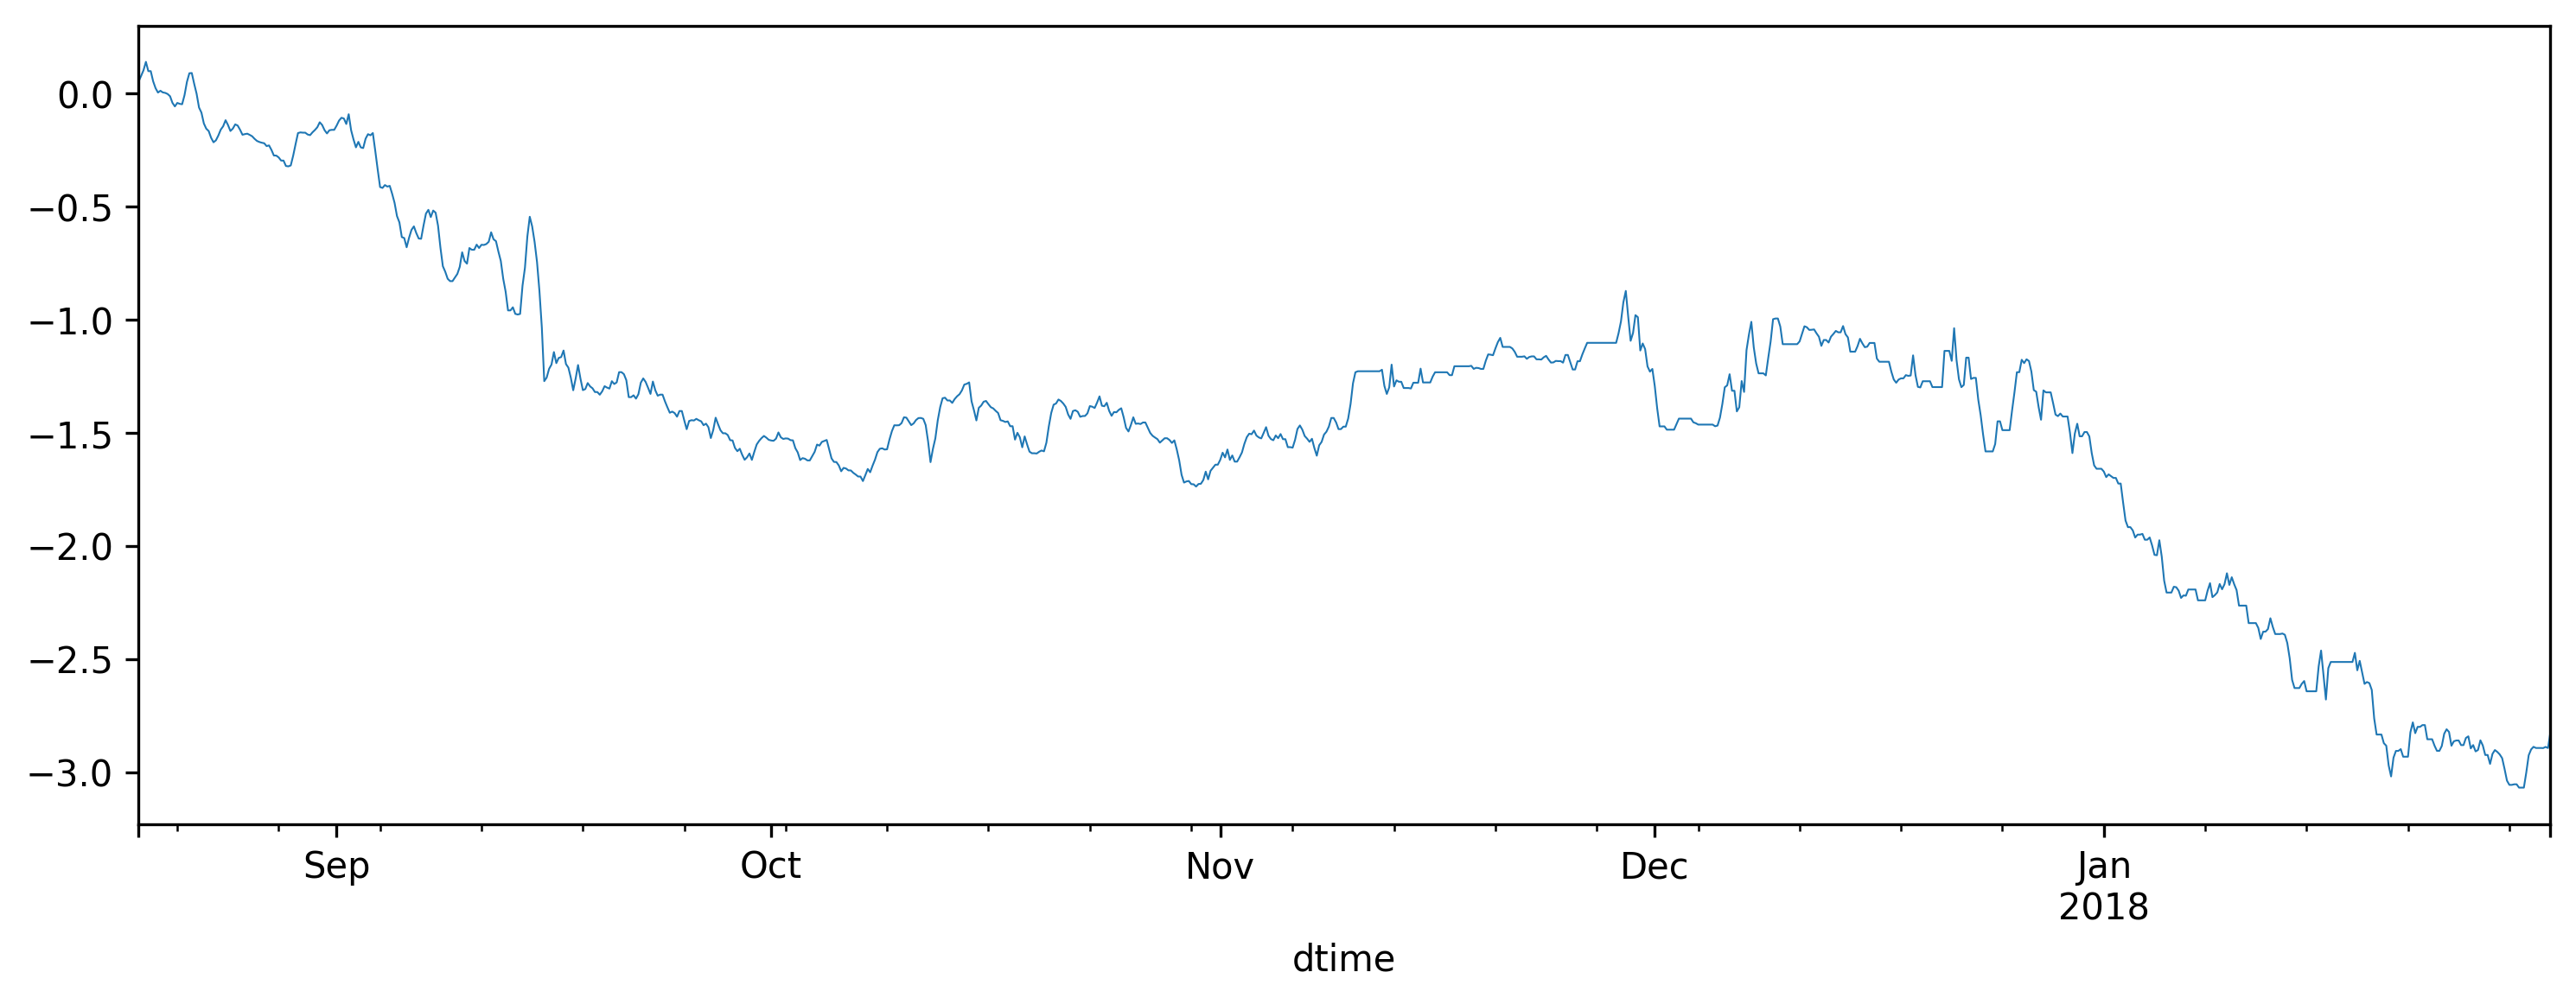

In [83]:
qdf = pd.DataFrame(agent.q_values.items())
sel_action = qdf.apply(lambda x: (np.argmax(x[1])), axis=1)
# sel_action = sel_action - 2*(sel_action > 1)

qdf['oaction'] = np.where(sel_action == 2, -1, sel_action)
qdf.set_index(0, inplace=True)
qdf
# qdf
# np.array(agent.q_values.items())
# qdf.reset_index()00
# agent.q_values
# current_future_prices.close_ret

rets = X_train.iloc[:1000].join(qdf.oaction, on='state_features')[['close_ret', 'oaction']].fillna(0)
# rets.isnull().sum()
rets['pnl'] = rets.close_ret * rets.oaction 
rets.pnl.cumsum().plot(figsize=(12,4))
# rets[rets.notna()]
# X_test
# rets.shape

In [272]:
env.unwrapped.action_space

Discrete(3)

In [18]:
vec_env = model.get_env()
action_stats = {0:0, 1:0}
total_reward = 0

obs = vec_env.reset()

max_range = len(df) - 12 # max. range for env.render_all()

for i in range (max_range):

    action, _states = model.predict(obs)
    action_stats[action[0]] += 1

    obs, reward, done, info = vec_env.step(action)
    total_reward += reward

print("action_stats:", action_stats)
print("total_reward:", total_reward)

vec_env.close()

action_stats: {0: 7715, 1: 4949}
total_reward: [6.7194835e+08]


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.render_all to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_all` for environment variables or `env.get_attr('render_all')` that will search the reminding wrappers.
  logger.warn(


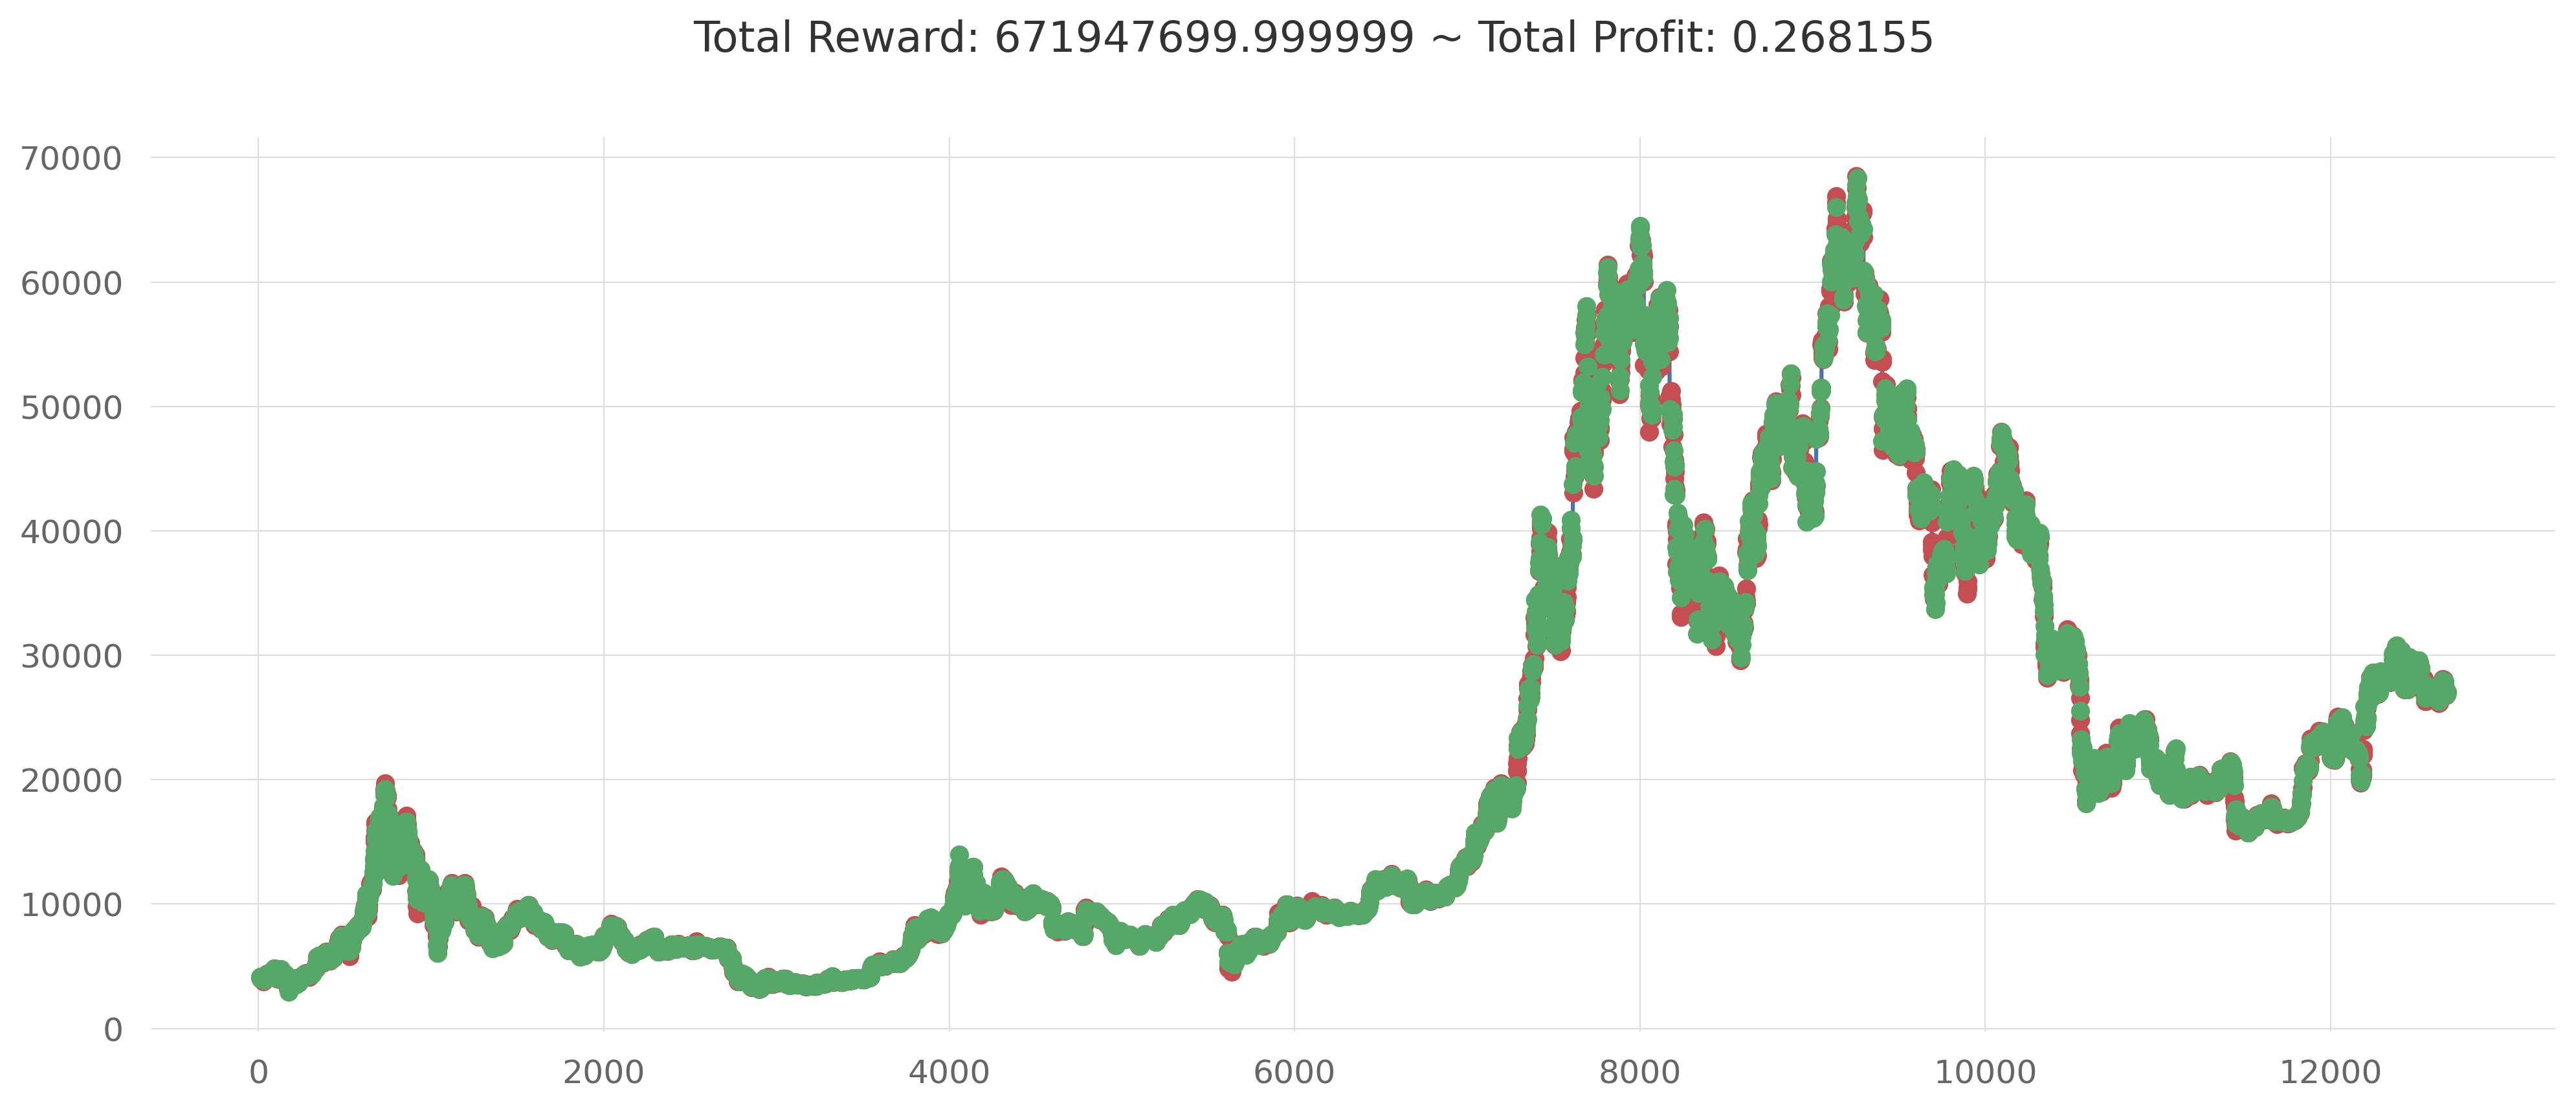

In [11]:
plt.figure(figsize=(16, 6))
env.render_all()
plt.show()